# Var Xi Topo MWTA

## Intro
* **Date**: 1/14/2021
* **What**: Basically just throwing a Var Xi invariant layer on top of a topo MWTA layer.  
* **Why**: Well, I need invariance don't I?  Also, the topological connections in the MWTA layer already seem to organize the sparse features into affinity groups, so I think the invariant prototypes will be far more organized if they're learning on top of an topologically organized feature space.
* **Hopes**: I want the network to organize itself nicely both topologically, and in terms of the invariant affinity groups.
* **Limitations**: Don't really know.  I think topology may be having detrimental affects on the quality of the sparse features learned, but I'm not sure.  It's certainly the case that the neurons on the edges of the sparse layer recieve far less attetion than the ones in the middle.  You know what?  I could fix that by making the sparse layer the topological equivalent of a torus.  Hmm.  I'll look into that.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

In [2]:
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 0

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

<IPython.core.display.Javascript object>


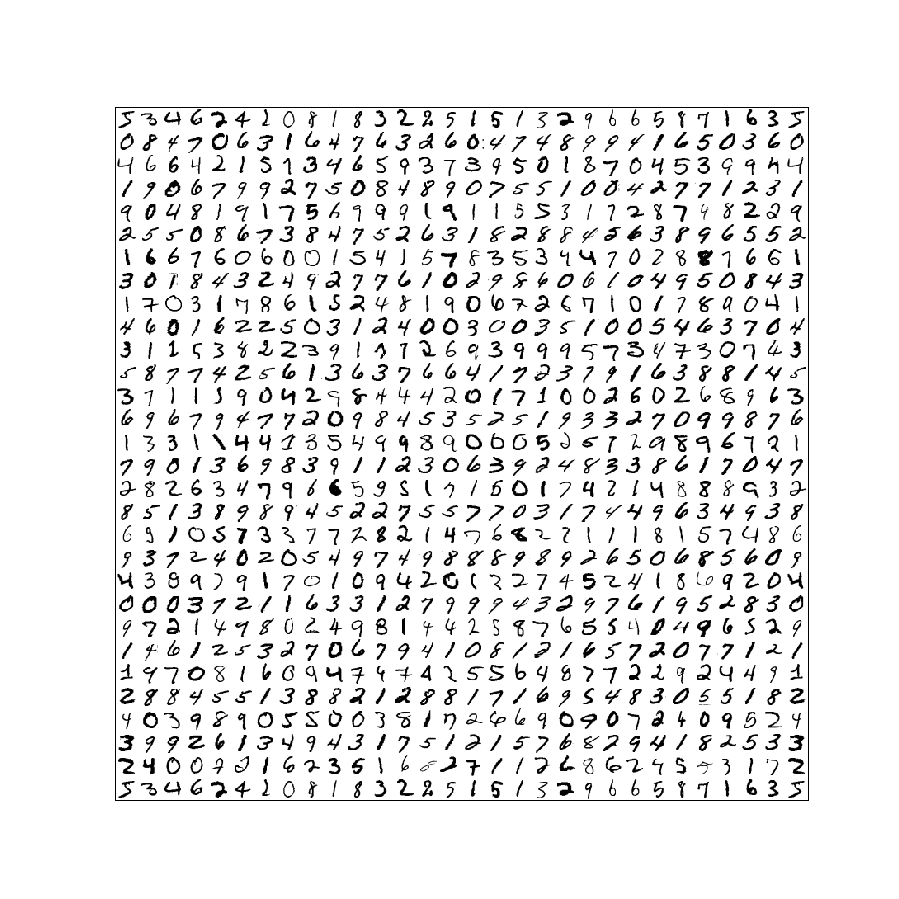

In [3]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

In [4]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])

<IPython.core.display.Javascript object>


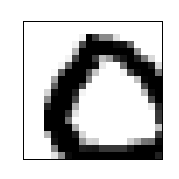

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(2, 2))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

In [8]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

This is the code to initialize torus topology.  It's kinda really annoying.

In [ ]:
Kx = 10
Ky = 10
ex = 2

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1
        
        if y - ex < 0:
            curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
        if y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            
        if x - ex < 0:
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
        if x + ex + 1 > Kx:
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1
            
        if y - ex < 0 and x - ex < 0:
            curr_ex[y - ex:, x - ex:] = 1
            
        if x + ex + 1 > Kx and y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1
            
        if y - ex < 0 and x + ex + 1 > Kx:
            curr_ex[y - ex:, :x + ex + 1 - Kx] = 1
            
            
        if x - ex < 0 and y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, x - ex:] = 1
            
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.5
np.fill_diagonal(lat_ex, 1)

## Analysis Dialog

Stay bouncy, my friends.

<IPython.core.display.Javascript object>


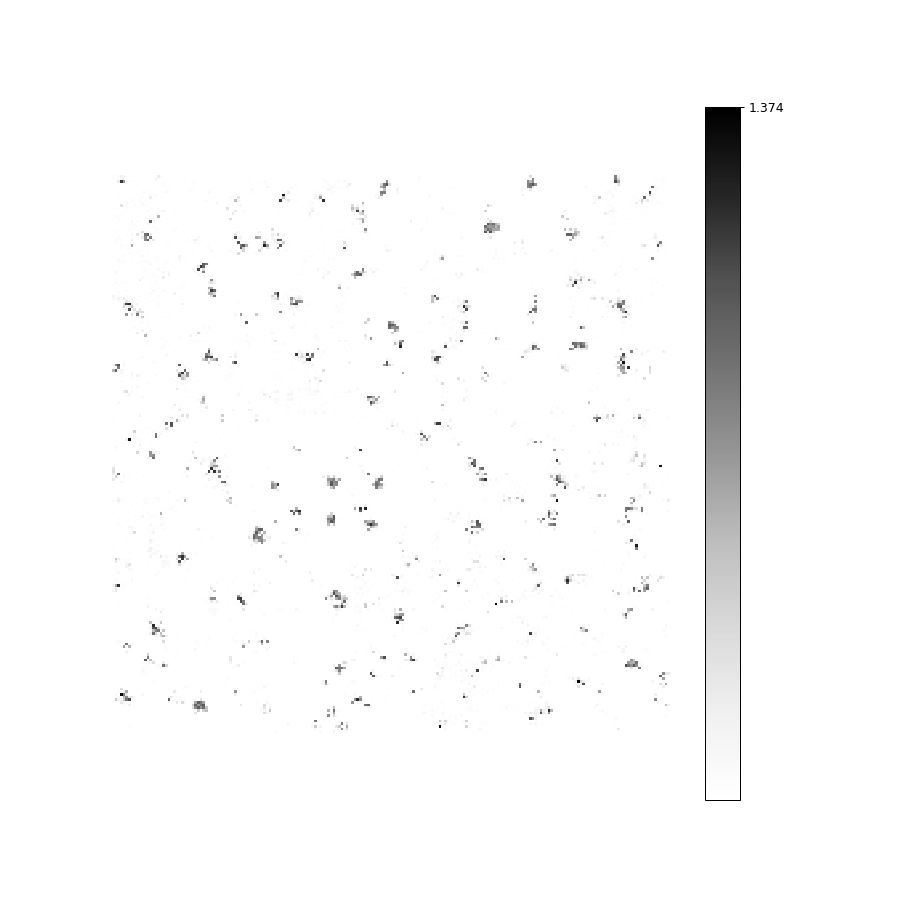

100%|██████████| 10000/10000 [00:09<00:00, 1043.37it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2
ex = 2

n_w = 4 #Number of winners

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
cp.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.5
cp.fill_diagonal(lat_ex, 1)

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.008

# Invariant Layer
Ix = 7
Iy = 7
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.05
seta = 0.0005

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = lat_ex @ p
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = 18 * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Dangarang.  Just look at those clusters.

Let's see the affinity groups.

<IPython.core.display.Javascript object>


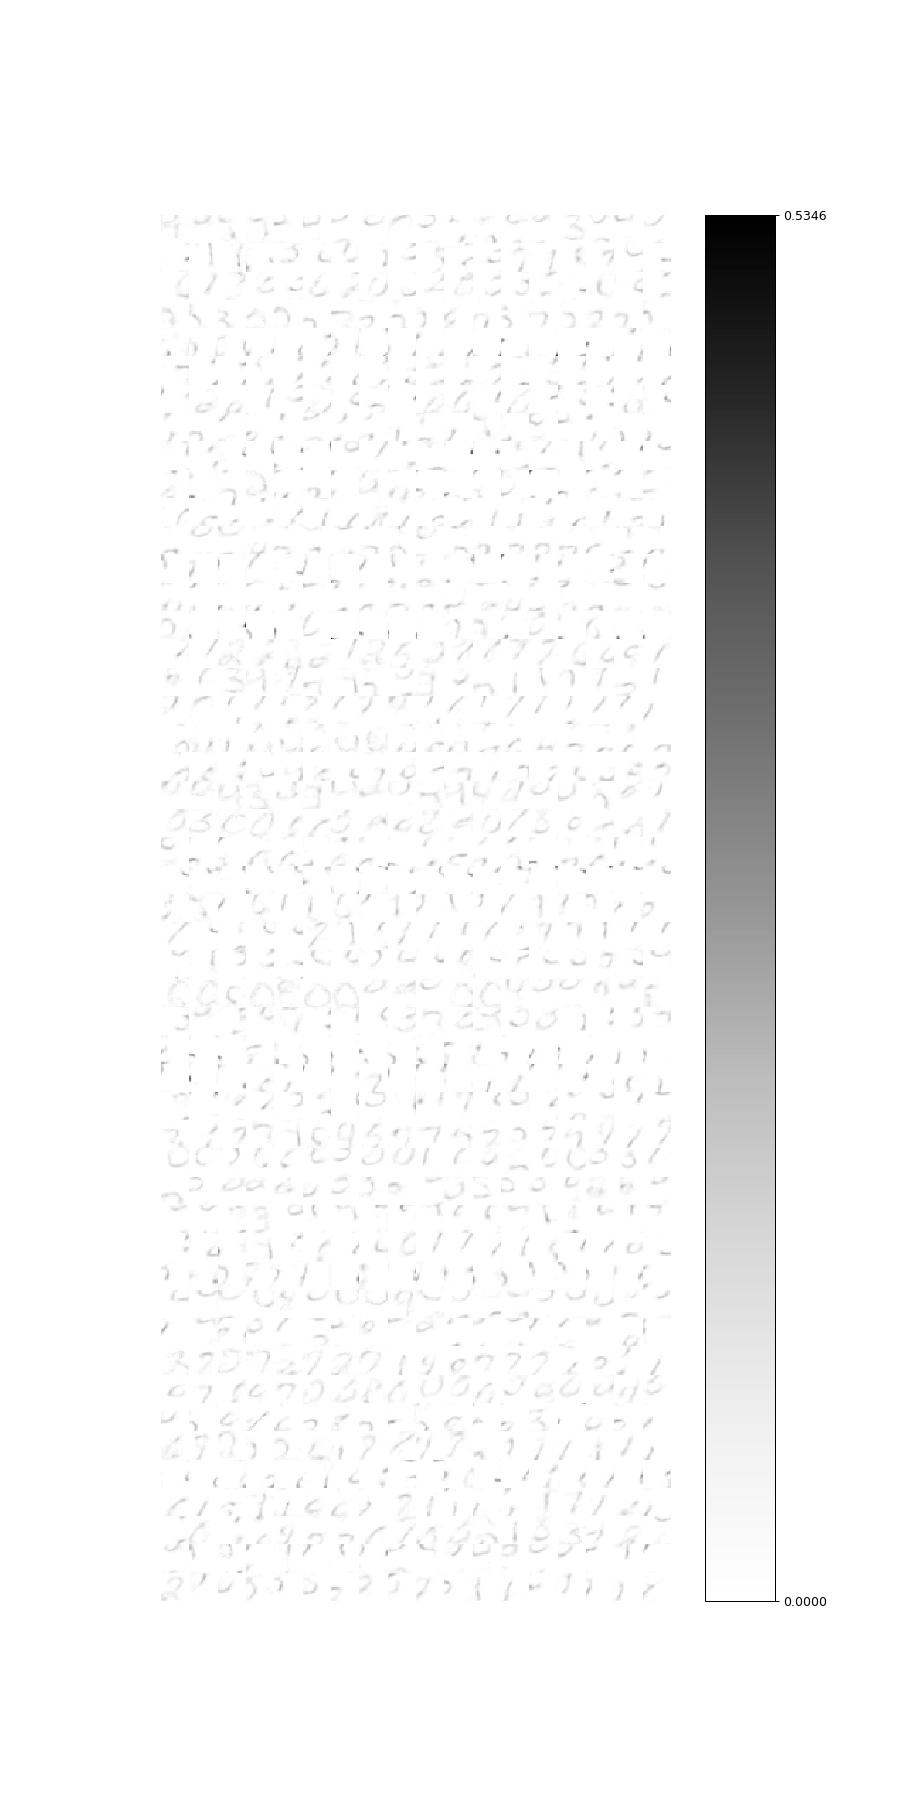

In [11]:
fig = plt.figure(figsize=(10, 20))

draw_weights(sw[cp.argsort(iw, axis=1)][:, -18:].reshape(882, 400).get(), 18, 49, 20, fig)

<IPython.core.display.Javascript object>


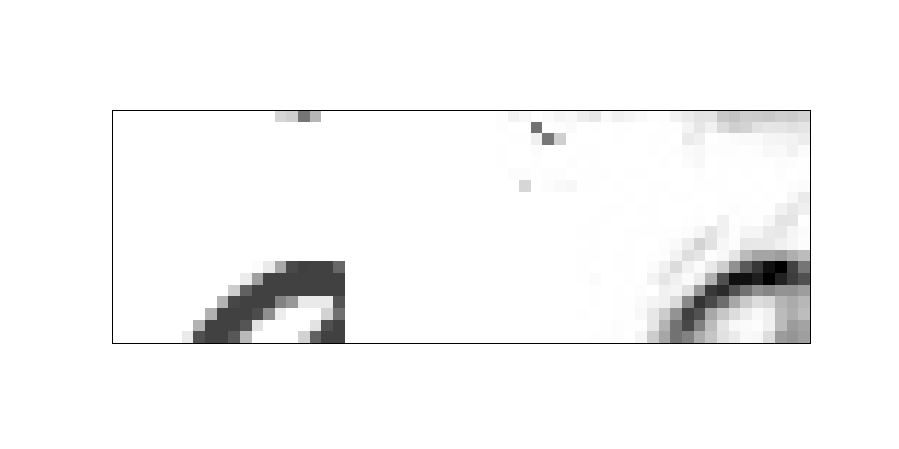

100%|██████████| 500/500 [00:00<00:00, 504.77it/s]


In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 7
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, this is a perfect example showing the fact that some of the neurons simply aren't training enough.  Ok, I think building the topo torus actually won't be super hard.  But first I want to finish running the invariant diagrams.

<IPython.core.display.Javascript object>


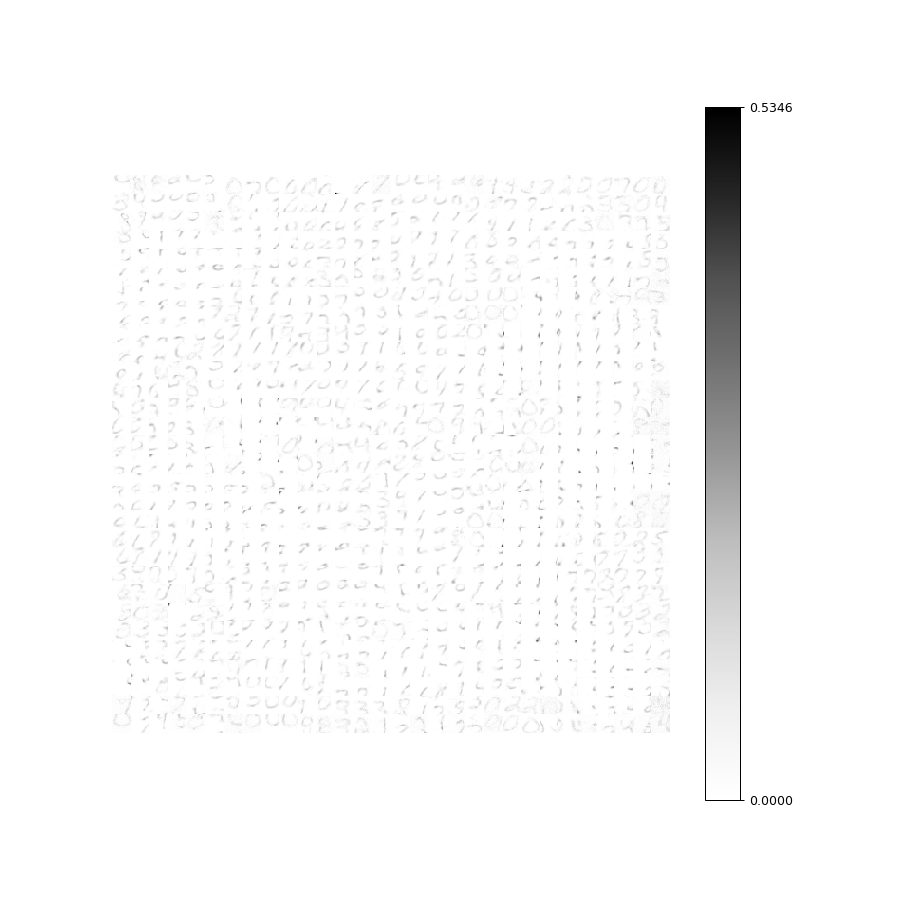

In [15]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

Wow that actually looks remarkably well-kempt.  There are just a couple prototypes in there that aren't doing so hot.  

<IPython.core.display.Javascript object>


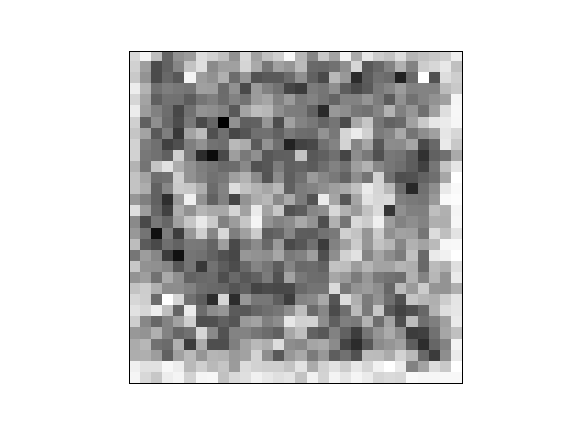

In [17]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray_r")

Oh shoot.  I just realize I was using the wrong colormap for the invariant experiment for that particular diagram.  That actually isn't a huge deal though.  This only just confirms what would naturally make sense.  Let's plot the best and worst.

<IPython.core.display.Javascript object>


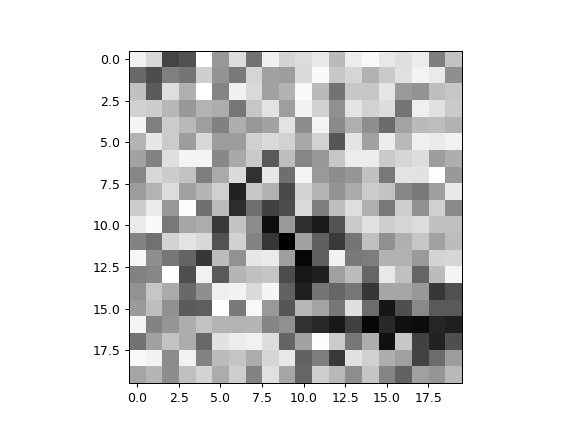

0.00027790639964620834
359


In [19]:
plt.figure()
print(np.min(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
print(np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Yeah that straight-up sucks.  I think that's one on the far-right middle edge.  Yeah that prototype sucks.

<IPython.core.display.Javascript object>


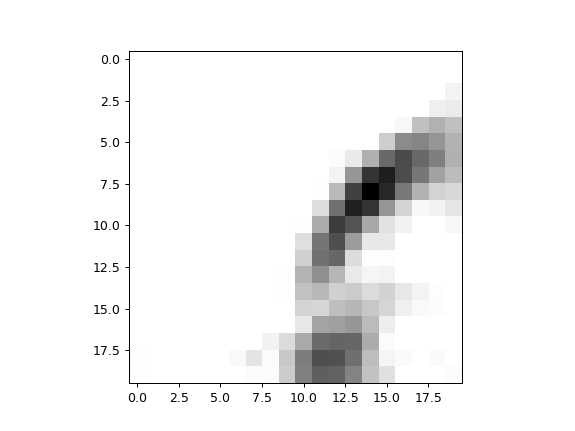

2.3333565201667588


In [20]:
plt.figure()
print(np.max(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

I guess that makes sense.  Ok, time to sew together the topology.

<IPython.core.display.Javascript object>


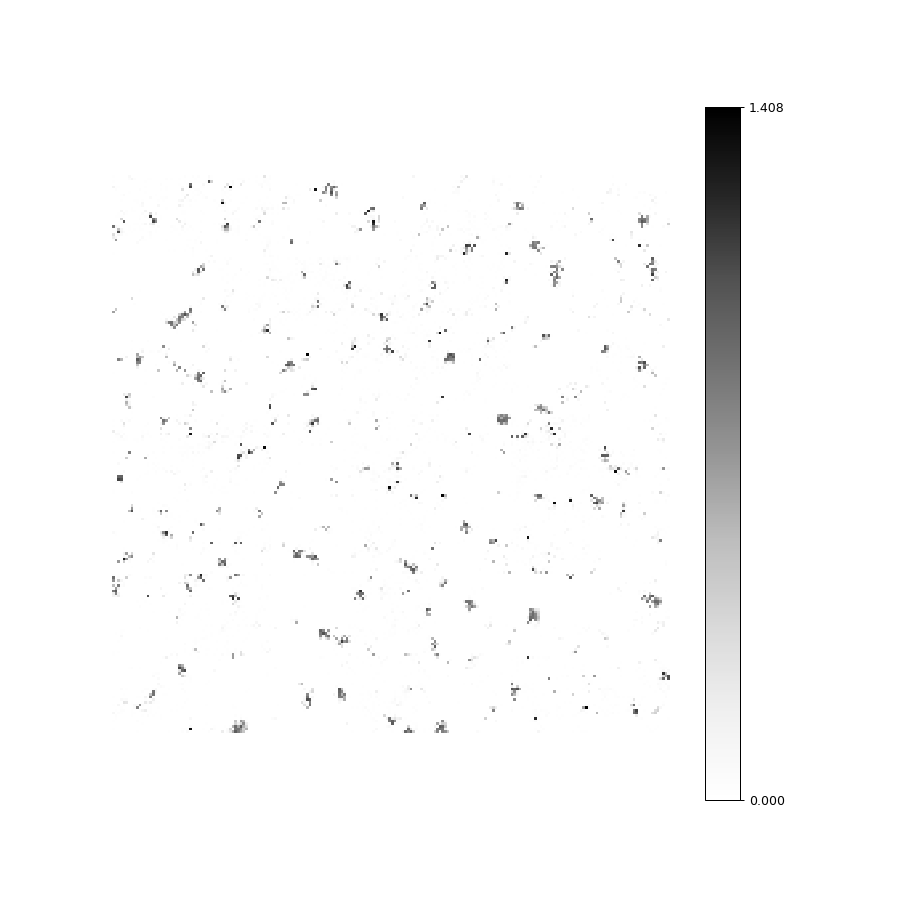

100%|██████████| 10000/10000 [00:09<00:00, 1038.45it/s]


In [142]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2
ex = 2

n_w = 4 #Number of winners

lat_ex = []

# Initializing torus topology is kinda the worst
for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1
        
        if y - ex < 0:
            curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
        if y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            
        if x - ex < 0:
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
        if x + ex + 1 > Kx:
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1
            
        if y - ex < 0 and x - ex < 0:
            curr_ex[y - ex:, x - ex:] = 1
            
        if x + ex + 1 > Kx and y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1
            
        if y - ex < 0 and x + ex + 1 > Kx:
            curr_ex[y - ex:, :x + ex + 1 - Kx] = 1
            
            
        if x - ex < 0 and y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, x - ex:] = 1
            
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.5
np.fill_diagonal(lat_ex, 1)

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.008

# Invariant Layer
Ix = 7
Iy = 7
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.05
seta = 0.0005

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = lat_ex @ p
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = 18 * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Ok, I think the torus was actually great.  Let's get some affinity groups going up in here.

<IPython.core.display.Javascript object>


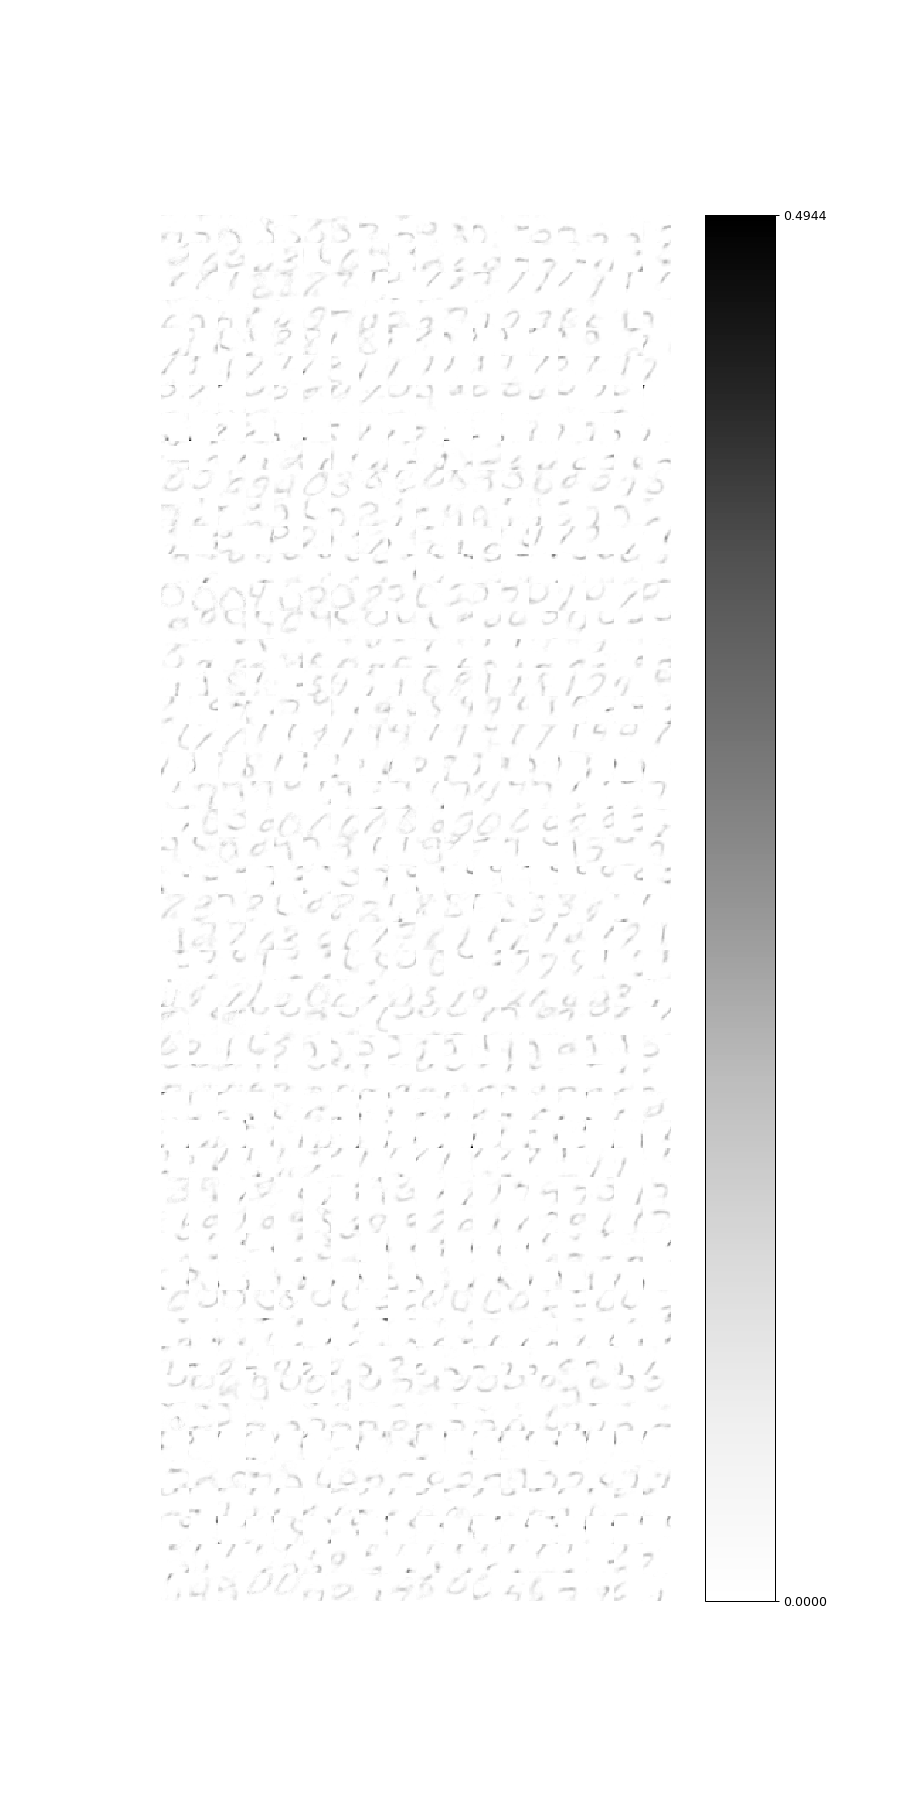

In [143]:
fig = plt.figure(figsize=(10, 20))

draw_weights(sw[cp.argsort(iw, axis=1)][:, -18:].reshape(882, 400).get(), 18, 49, 20, fig)

Dope.  Let's check out the overall coverage.

Actually I'll just do the full analysis.

<IPython.core.display.Javascript object>


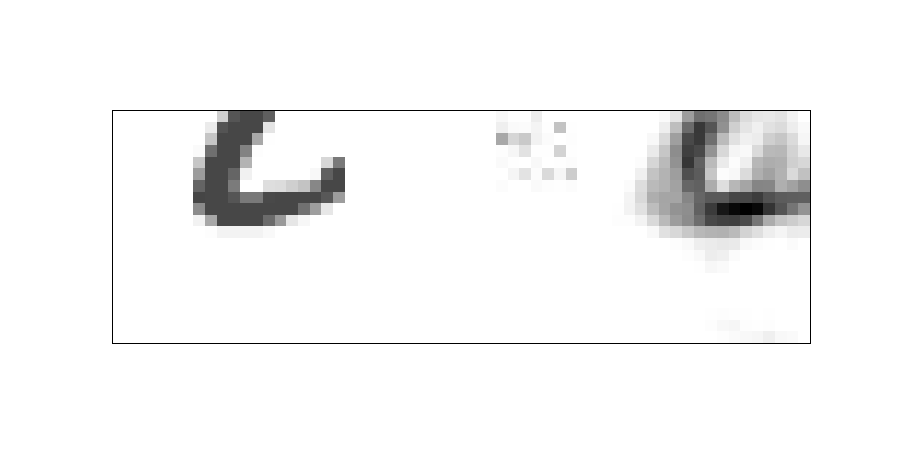

100%|██████████| 500/500 [00:00<00:00, 502.41it/s]


In [144]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 7
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


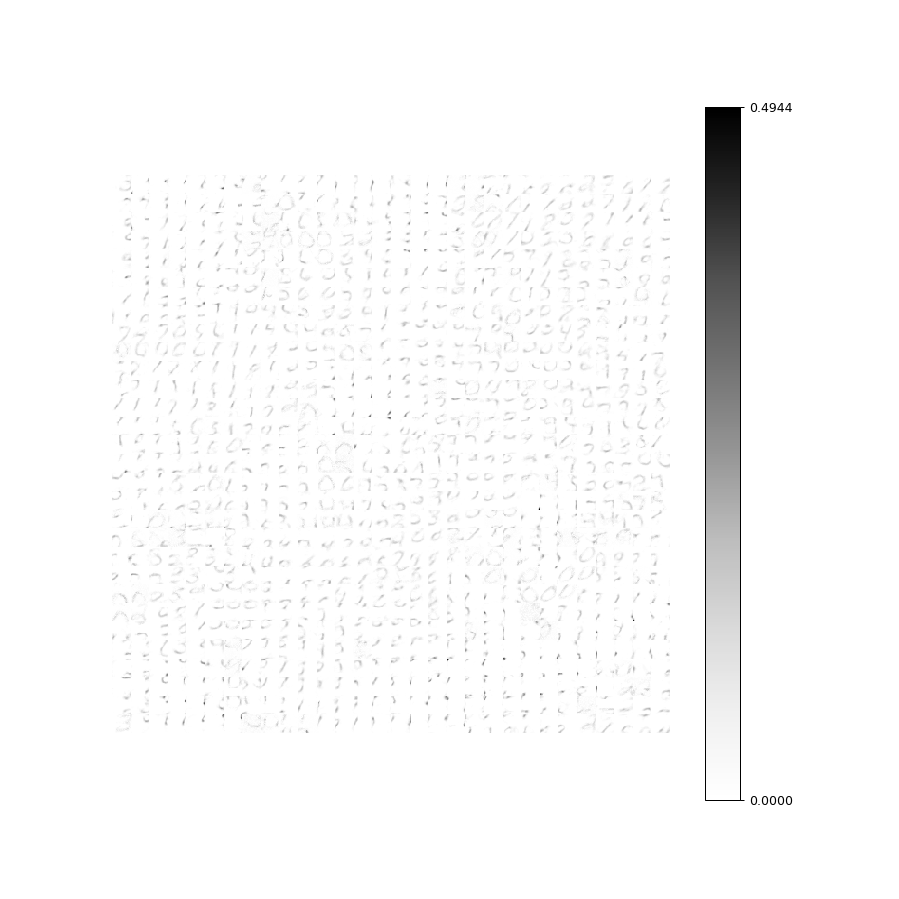

In [145]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


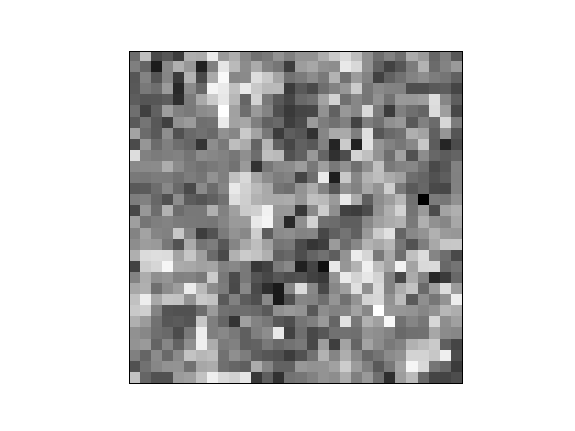

In [146]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray_r")

<IPython.core.display.Javascript object>


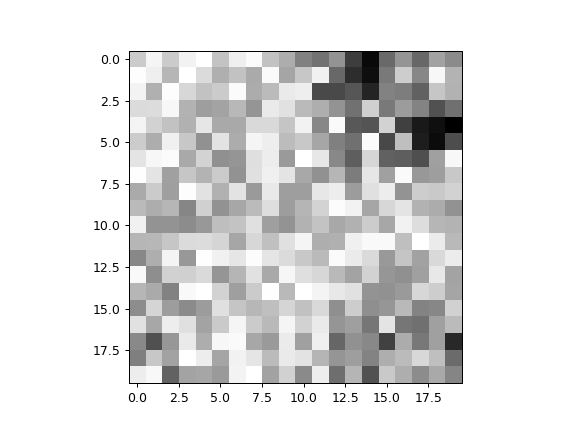

0.000498906070688955
712


In [147]:
plt.figure()
print(np.min(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
print(np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Yeah that straight-up sucks.  I think that's one on the far-right middle edge.  Yeah that prototype sucks.

<IPython.core.display.Javascript object>


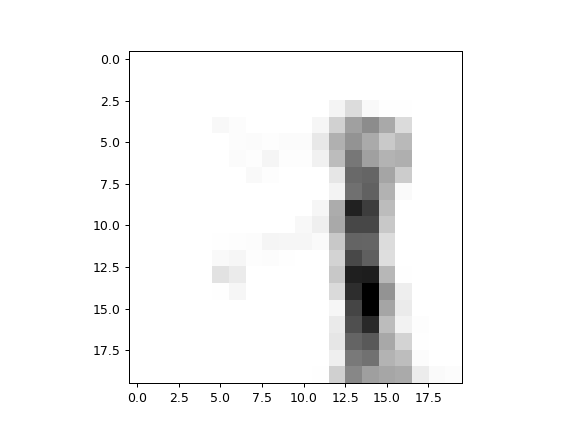

2.107146714122171


In [148]:
plt.figure()
print(np.max(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Ok, this is pretty fantastic.  I think the thing to do now is simply increase the size of both layers.

<IPython.core.display.Javascript object>


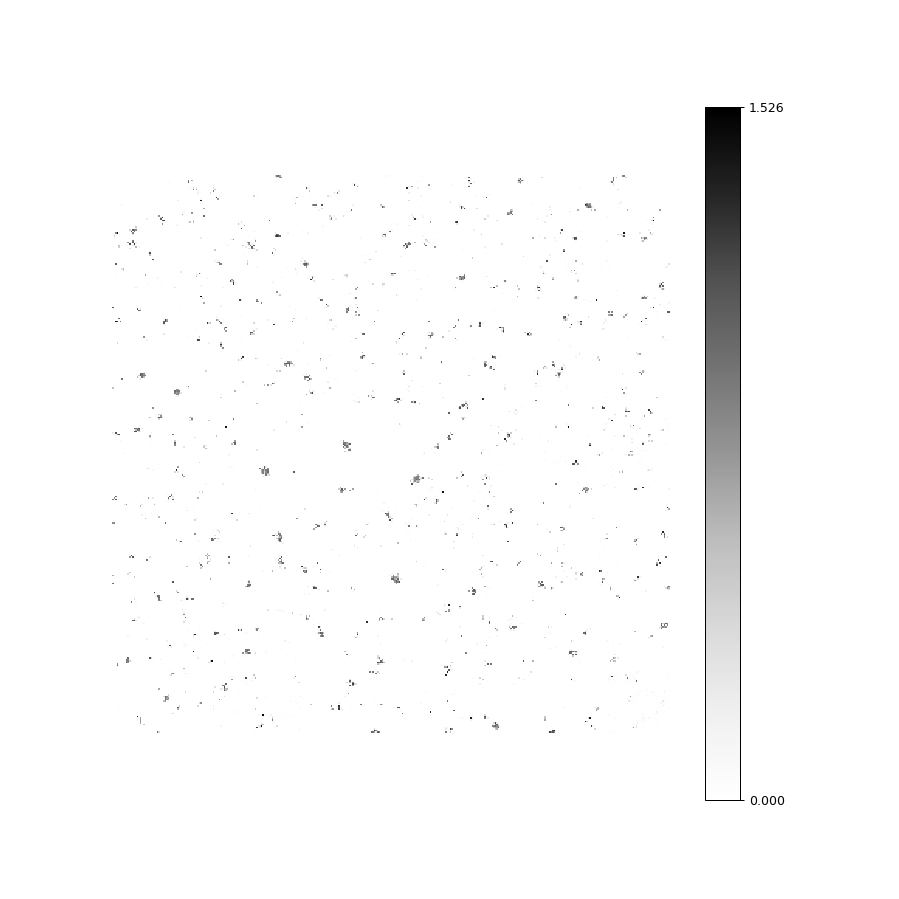

100%|██████████| 10000/10000 [00:10<00:00, 979.21it/s]


In [149]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 40
Ky = 40
sN = Kx * Ky
m_len = sl ** 2
ex = 2

n_w = 4 #Number of winners

lat_ex = []

# Initializing torus topology is kinda the worst
for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1
        
        if y - ex < 0:
            curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
        if y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            
        if x - ex < 0:
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
        if x + ex + 1 > Kx:
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1
            
        if y - ex < 0 and x - ex < 0:
            curr_ex[y - ex:, x - ex:] = 1
            
        if x + ex + 1 > Kx and y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1
            
        if y - ex < 0 and x + ex + 1 > Kx:
            curr_ex[y - ex:, :x + ex + 1 - Kx] = 1
            
            
        if x - ex < 0 and y + ex + 1 > Ky:
            curr_ex[:y + ex + 1 - Ky, x - ex:] = 1
            
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = cp.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * 0.5
np.fill_diagonal(lat_ex, 1)

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.02

# Invariant Layer
Ix = 9
Iy = 9
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.08
seta = 0.0008

for ep in range(Nep):
    inputs = gp_data
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        c = lat_ex @ p
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = 18 * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Ok, we're seeing great clustering and all that.  Also I realized that I haven't been taking lateral excitation into consideration for the animations.  That's probably why some of the frames are clearly very poorly processed.

<IPython.core.display.Javascript object>


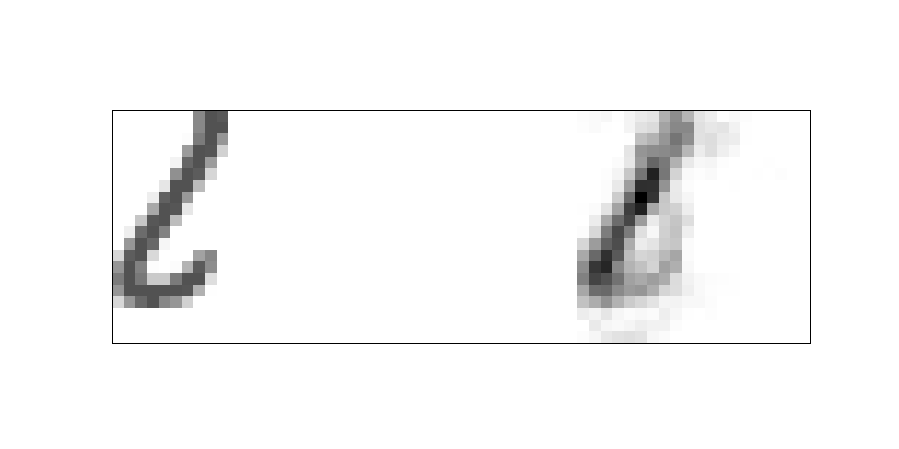

100%|██████████| 500/500 [00:01<00:00, 330.15it/s]


In [154]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()
lx_np = lat_ex.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    c = lx_np @ p
    winners = np.argsort(c, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
#     glee = 7
    
    mini_tap[:, :20] = v.reshape(20, 20)
#     mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, the animation is pretty dope.  Seems like the network is doing a pretty good job.

<IPython.core.display.Javascript object>


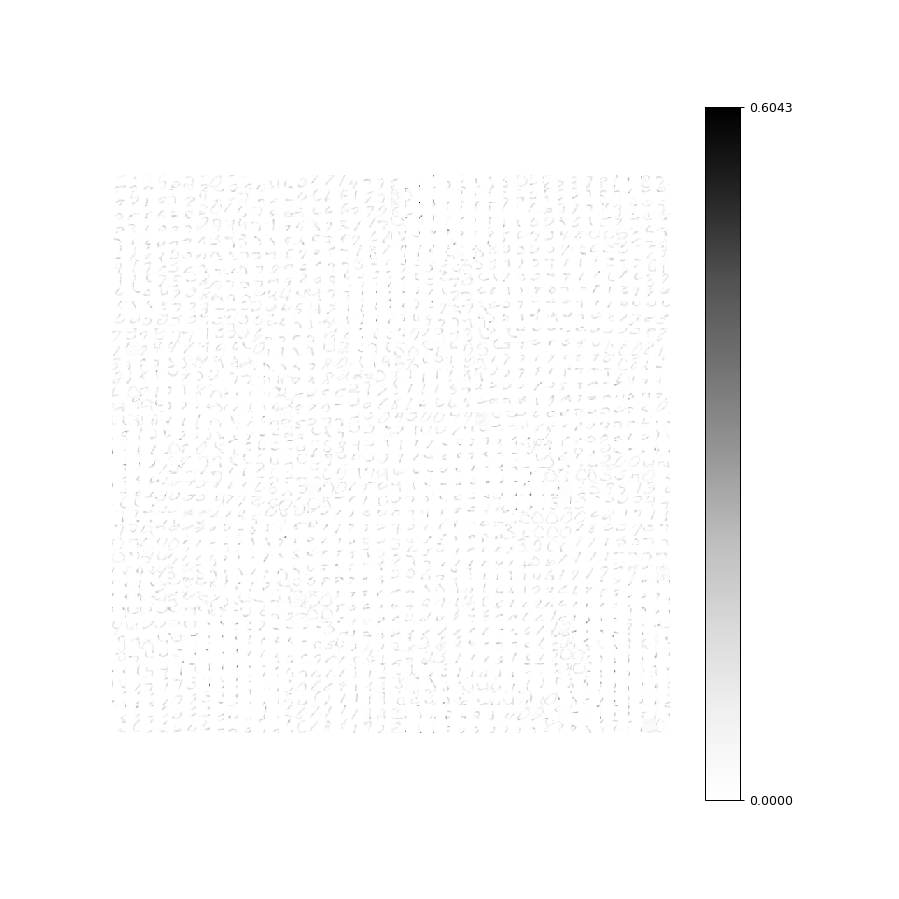

In [155]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


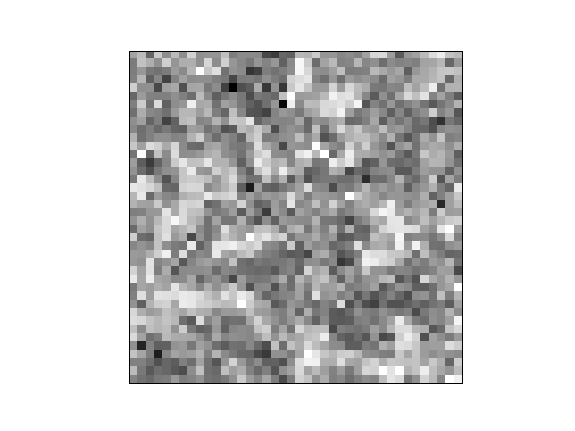

In [156]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray_r")

<IPython.core.display.Javascript object>


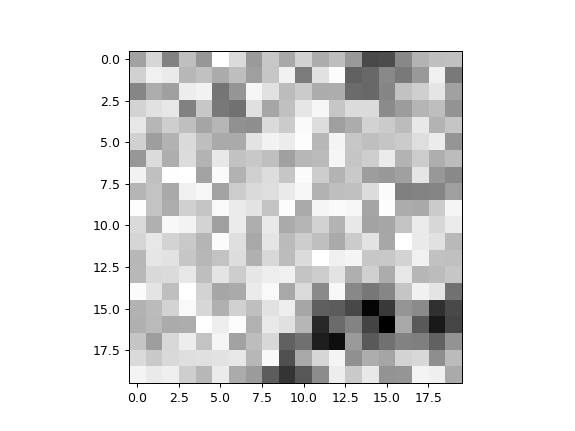

9.226713975528303e-05
1598


In [157]:
plt.figure()
print(np.min(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
print(np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Yeah that straight-up sucks.  I think that's one on the far-right middle edge.  Yeah that prototype sucks.

<IPython.core.display.Javascript object>


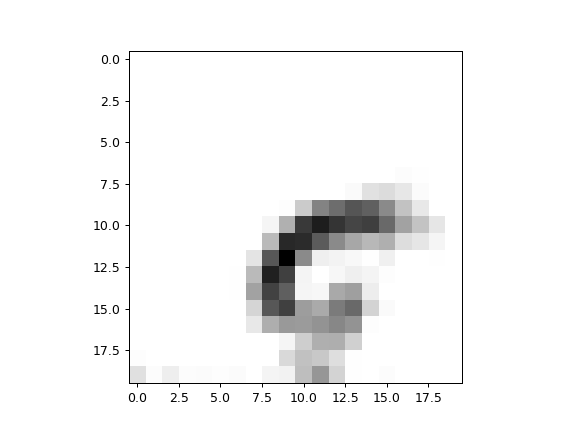

2.301064365589955


In [158]:
plt.figure()
print(np.max(cp.sum(iw, axis=0).reshape(Kx, Ky).get()))
plt.imshow(sw.get()[np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Ok, I think this is great.  I think I'm going to wrap this experiment up.

## Conclusions

First things first, the torus topology is fantastic, and also I had a bug in initializing the right hand side of the lateral excitation, so I'm glad I implemented the former, and fixed the later.  Now the feature space is nicely organized, and the edges aren't a problem anymore.

Second things second, this basically did exactly what I wanted it to do.  The invariant prototypes are far more clustered than they were previously, which is really just fantastic, because self-organizing systems are incredibly dope.  

Third things third, increased activity level wherever there's an ema is great because it signifies movement in some capacity.  So basically, the objective function for focusing on one feature despite a moving environment should be simply minimizing the activity in any layer in which there's an ema. That's dope.

## Next steps

I'm actually going to spend a bit of time thinking about how to translate what I've learned about ema into a learned feedback loop.  Learning how to properly tune a feedback loop could be incredibly useful.  I might actually see what's already out there.  Well, whatever.  We'll see.  I think this is probably incredibly important, however.  

Also, creating an MNIST classifier is probably next on the list of things to do.  I might make it topological just for kicks and giggles.  We'll see what happens.